In [1]:
from arpes.io import load_data
from arpes.utilities.conversion import convert_to_kspace

import os.path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import math
import numpy as np
import xarray as xr
from scipy import signal


C:\Users\fb7365\Documents\CODES\arpes\arpes\config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2023-10-18_09-29-51.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


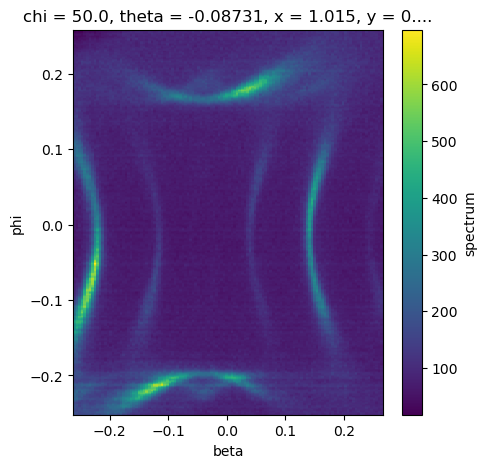

In [2]:
path = os.path.abspath("E:/DATA/EPFL/ARPES/e19775/Box_1_square_renamed")

good_scans = ['FS_N_P50_26p5eV_CIRCM_LT_10eVpass_0000']
angle_offsets = {}
angle_offsets["Bi2223"] = {
    "phi": 0.075,    # controls the offset along the analyzer center axis
    "theta": 0,
    "chi": 49.999125,    # sample rotation, controls kx-ky plane orientation
    "alpha": 0,
    "beta": -0.04,
}

bi2223_data_list = {}
for file in [good_scans[0]]:
    raw_data = load_data(path+ os.sep+ file+'.h5', location="ULTRA")
    file_name = file
    bi2223_data_list.update({file_name : raw_data})
    
scan = bi2223_data_list[good_scans[0]]

fig, ax = plt.subplots(figsize = (5,5))

data = scan.spectrum
fs = data.sel(eV=slice(-0.02,0.02)).sum("eV")
fs.plot(ax=ax)

<IPython.core.display.Javascript object>


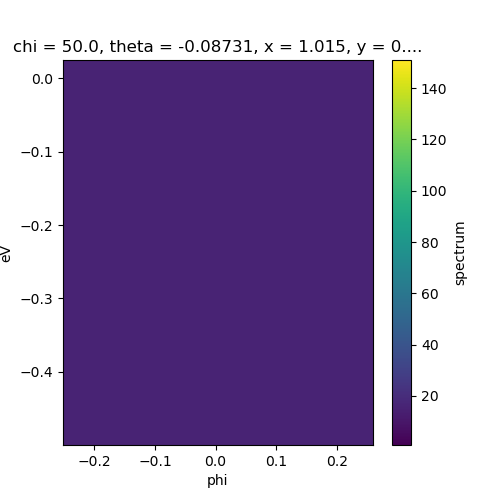

In [6]:
%matplotlib notebook

fig, ax = plt.subplots(figsize = (5,5))
# A = scan.sel(phi=slice(-0.02, 0.02), beta=slice(-0.5,0.5), eV=slice(-0.125, 0.025)).sum("phi")
A = scan.sel(phi=slice(-0.5, 0.5), beta=slice(-0.1,-0.05), eV=slice(-0.5, 0.025)).sum("beta")

A.spectrum.plot(ax = ax)

<IPython.core.display.Javascript object>


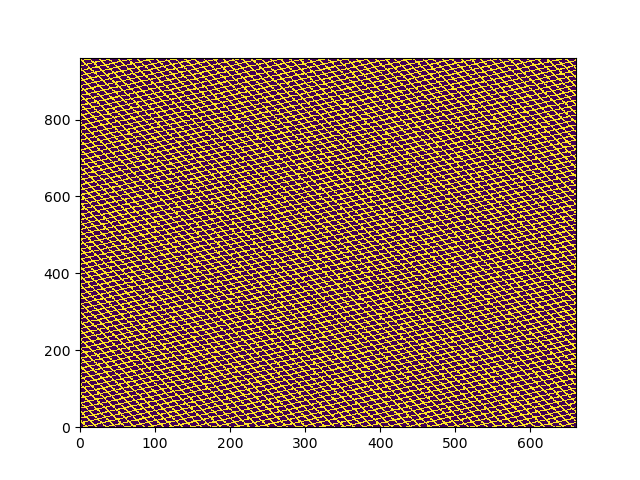

<IPython.core.display.Javascript object>


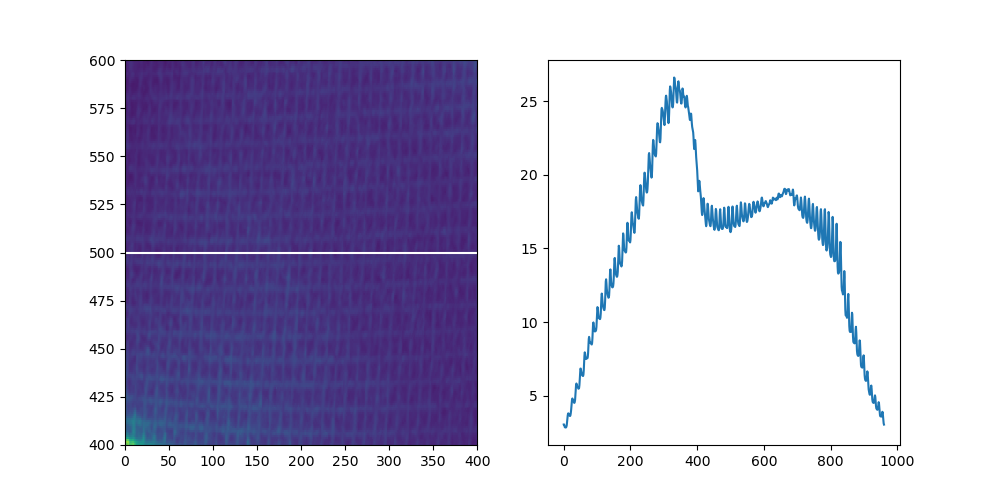

In [7]:
import scipy.fftpack as sfft
import skimage as sk
from scipy.signal import medfilt2d
A = scan.sel(beta=slice(-0.1,-0.05)).sum("beta")
grid = np.array(A.spectrum)



grid1 = [0.45, 501]
grid2 = [-1.85, 698]

x_pixel = np.arange(np.size(grid,1))
y_pixel = np.arange(np.size(grid,0))

pitch1 = 12.9
pitch2= 23.5

plt.pcolormesh(x_pixel, y_pixel, grid, vmin = 0, vmax =100)

# for i in np.arange(-50, 30, 1):
#     plt.plot(x_pixel, grid2[0]*x_pixel + grid2[1]+i*pitch2, c= 'r', ls = '--')

# # plt.plot(x_pixel, grid1[0]*x_pixel + grid1[1], c= 'w', ls = '--')
# plt.plot(x_pixel, grid2[0]*x_pixel + grid2[1], c= 'r', ls = '--')

# plt.plot(x_pixel, grid1[0]*x_pixel + grid1[1] + pitch, c= 'w', ls = '--')


grid_simulated = np.zeros([np.size(grid,0), np.size(grid,1)])

for i in np.arange(0, np.size(grid_simulated, 0)):
    for j in np.arange(0, np.size(grid_simulated, 1)):
        if ((i -  grid1[0]* j - grid1[1]) % pitch1 <1.5)  |  ((i -  grid1[0]* j - grid1[1]) % pitch1 >pitch1-1.5) : 
            grid_simulated[i,j]  =100
        if ((i -  grid2[0]* j - grid2[1]) % pitch2 <2.5)  |  ((i -  grid2[0]* j - grid2[1]) % pitch2 >pitch2-2.5) : 
            grid_simulated[i,j]  =100


plt.figure()
plt.pcolormesh(grid_simulated)


# for i in np.arange(-50, 30, 1):
#     plt.plot(x_pixel, grid2[0]*x_pixel + grid2[1]+i*pitch2, c= 'r', ls = '--')
# for i in np.arange(-50, 30, 1):
#     plt.plot(x_pixel, grid1[0]*x_pixel + grid1[1]+i*pitch1, c= 'w', ls = '--')


#%%
grid_rot = sk.transform.rotate(grid, -58)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.pcolormesh(grid_rot)
plt.axhline(500, c='w')
plt.xlim([0, 400])
plt.ylim(400, 600)
plt.subplot(122)
plt.plot(np.nanmean(grid_rot, 1))



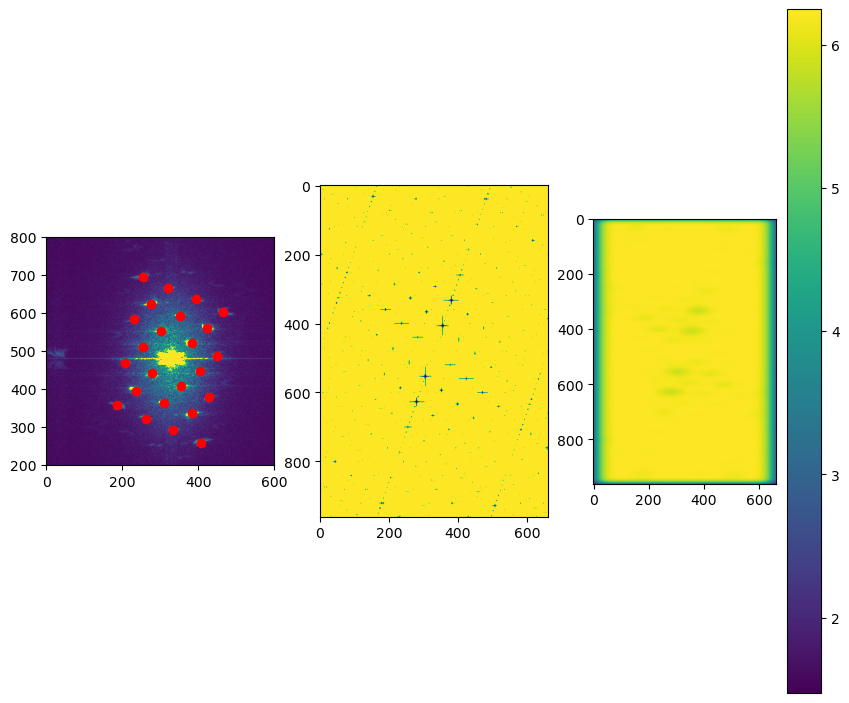

In [145]:
#
grid1 = [0.5, 501]
grid2 = [-1.7, 698]

x_pixel = np.arange(np.size(grid,1))
y_pixel = np.arange(np.size(grid,0))

pitch1 = 13.1
pitch2= 24
grid_simulated = np.zeros([np.size(grid,0), np.size(grid,1)])

for i in np.arange(0, np.size(grid_simulated, 0)):
    for j in np.arange(0, np.size(grid_simulated, 1)):
        if ((i -  grid1[0]* j - grid1[1]) % pitch1 <1.5)  |  ((i -  grid1[0]* j - grid1[1]) % pitch1 >pitch1-1.5) : 
            grid_simulated[i,j]  =100
        if ((i -  grid2[0]* j - grid2[1]) % pitch2 <2.5)  |  ((i -  grid2[0]* j - grid2[1]) % pitch2 >pitch2-2.5) : 
            grid_simulated[i,j]  =100

simgrid_fft =  np.abs(sfft.fftshift(sfft.fft2(grid_simulated)))
simgrid_fft = simgrid_fft - np.mean(medfilt2d(simgrid_fft, [31,31]), axis=(0,1))

simgrid_fft[simgrid_fft<1e5] = 1
simgrid_fft[simgrid_fft>5e4] = 0


Z_fft = sfft.fft2(np.array(grid))
Z_shift = sfft.fftshift(Z_fft)

fig = plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow( np.abs(Z_shift), vmin = 0, vmax =1e4)


peaks_fft = {}
peaks_fft['x'] = [277, 354, 404, 384, 303, 255, 236, 310, 383, \
    427, 450, 424, 351, 275, 230, 208, 187, 261, 334, 406, 466, 394, 321, 255]
peaks_fft['y'] = [442, 407, 447, 520, 553, 510, 395, 364, 336, \
    379, 487, 560, 593, 625, 585, 469, 357, 322, 291, 258, 602, 638, 665, 696]

x_points = [280, 305, 310]
y_points = [440, 555, 370]

for i in range(len(peaks_fft['x'] )):
    plt.plot(peaks_fft['x'] [i], peaks_fft['y'] [i], marker = 'o', c='r')

plt.xlim(0, 600)
plt.ylim(200, 800)



sigma_x = 10
sigma_y = 30

dx = np.arange(-3*sigma_x, 3*sigma_x, 1  )
dy = np.arange(-3*sigma_y, 3*sigma_y, 1  )
gaussian_x = 1/sigma_x * np.exp(-((dx)/sigma_x)**2/2)
gaussian_y = 1/sigma_y *np.exp(-((dy)/sigma_y)**2/2)

conv_sim_grid = np.zeros(np.shape(simgrid_fft))

for i in range(len(y_pixel)):
    conv_sim_grid[i,:] = np.convolve(simgrid_fft[i,:], gaussian_y, mode="same")


for j in range(len(x_pixel)):
    conv_sim_grid[:,j] = np.convolve(conv_sim_grid[:,j], gaussian_x, mode="same")

plt.subplot(132)
plt.imshow(simgrid_fft, vmin = 0, vmax =1)
plt.subplot(133)
plt.imshow(conv_sim_grid )
plt.colorbar()


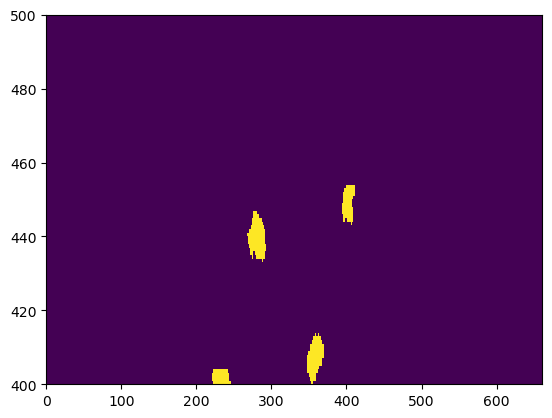

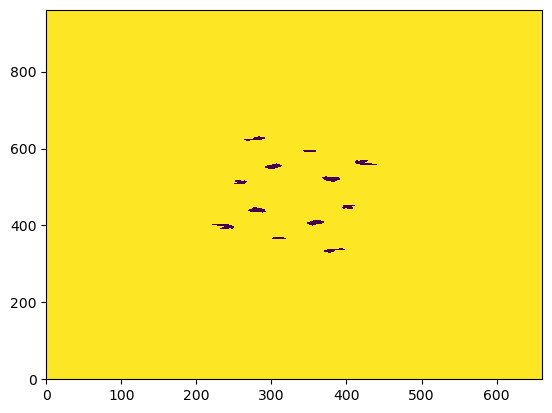

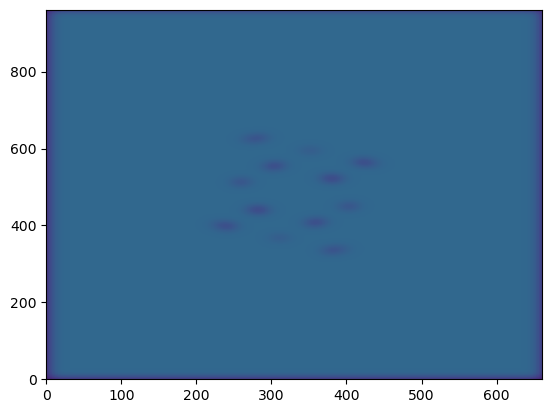

In [130]:
A = scan.sel(beta=slice(-0.1,-0.05)).sum("beta")
arpes_grid = np.array(A.spectrum)

Z_fft = sfft.fft2(np.array(arpes_grid))

# Z_fft = sfft.fft2(np.array(grid2))
Z_shift = sfft.fftshift(Z_fft)

fig = plt.figure()
plt.pcolormesh( np.abs(Z_shift), vmin = 0, vmax =100)

x_points = [280, 305, 310, ]
y_points = [440, 555, 370]

# for i in range(len(x_points)):
#     plt.plot(x_points[i], y_points[i], marker = 'o', c='r')

# plt.xlim(0, 600)
# plt.ylim(200, 800)
# plt.colorbar()


# plt.figure()
grid_fft = np.abs(Z_shift)

grid_fft[grid_fft<5000] = 0

xx = np.arange(0, np.size(grid_fft,0), 1)
yy = np.arange(0, np.size(grid_fft,1), 1)
width_x = 30
width_y = 60

intX_c = np.abs(xx - np.size(grid_fft,0)) < width_x
intY_c = np.abs(yy - np.size(grid_fft,1)) < width_y
for i in range(np.size(grid_fft, 0)):
    for j in range(np.size(grid_fft,1 )):
        if (np.abs(i - np.size(grid_fft,0)/2)**2/width_x**2 + np.abs(j - np.size(grid_fft,1)/2)**2/width_y**2 < 1) :
            grid_fft[i, j ] = 0
grid_fft[grid_fft<1e4] = 0 

plt.pcolormesh( medfilt2d(grid_fft,  [5,5] ), vmin = 0, vmax =1e4)
grid_fft_filt =  medfilt2d(grid_fft, [5,5])

grid_fft_filt = medfilt2d(grid_fft,  [5,5] )
plt.ylim(400, 500)
grid_fft_filt[grid_fft_filt==0] = 1
grid_fft_filt[grid_fft_filt>1] = 0
plt.figure()


sigma_x = 30
sigma_y = 10


dx = np.arange(-3*sigma_x, 3*sigma_x, 1  )
dy = np.arange(-3*sigma_y, 3*sigma_y, 1  )
gaussian_x = 1/np.sqrt(2*np.pi)/sigma_x * np.exp(-((dx)/sigma)**2/2)
gaussian_y = 1/np.sqrt(2*np.pi)/sigma_y  *np.exp(-((dy)/sigma)**2/2)


plt.pcolormesh( grid_fft_filt, vmin = 0, vmax =1)


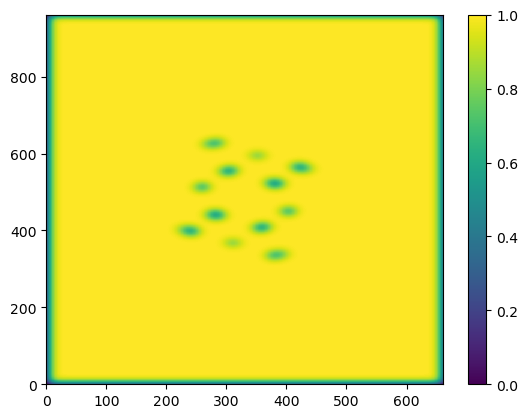

In [142]:
result = np.zeros(np.shape(grid_fft_filt))

for i in range(len(xx)):
    result[i,:] = np.convolve(grid_fft_filt[i,:], gaussian_x, mode="same")

for j in range(len(yy)):
    result[:,j] = np.convolve(result[:,j], gaussian_y, mode="same")

result-=np.min(result, axis = (0,1))
plt.figure()
plt.pcolormesh( (result) /np.max(result), vmin = 0, vmax =1)
plt.colorbar()


(600.0, 800.0)

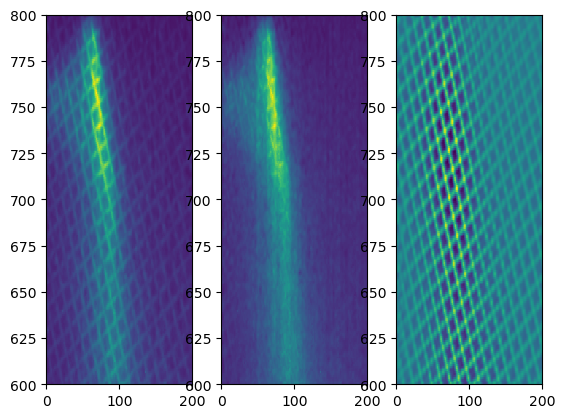

In [136]:
A = scan.sel(beta=slice(-0.1,-0.05)).sum("beta")
arpes_grid = np.array(A.spectrum)



Z_fft = sfft.fft2(np.array(arpes_grid))
filt_ARPES  = sfft.ifftshift( sfft.fftshift(Z_fft) * grid_fft_filt)


arpes_filtered = np.abs(sfft.ifft2(filt_ARPES))

grid2 = arpes_grid - arpes_filtered

plt.figure(fig)
plt.subplot(131)
plt.pcolormesh(grid)
plt.xlim([0, 200])
plt.ylim([600, 800])

plt.subplot(132)
plt.pcolormesh(arpes_filtered)
plt.xlim([0, 200])
plt.ylim([600, 800])

plt.subplot(133)
plt.pcolormesh(grid2)
plt.xlim([0, 200])
plt.ylim([600, 800])






Text(0.5, 1.0, 'subtracted grid ')

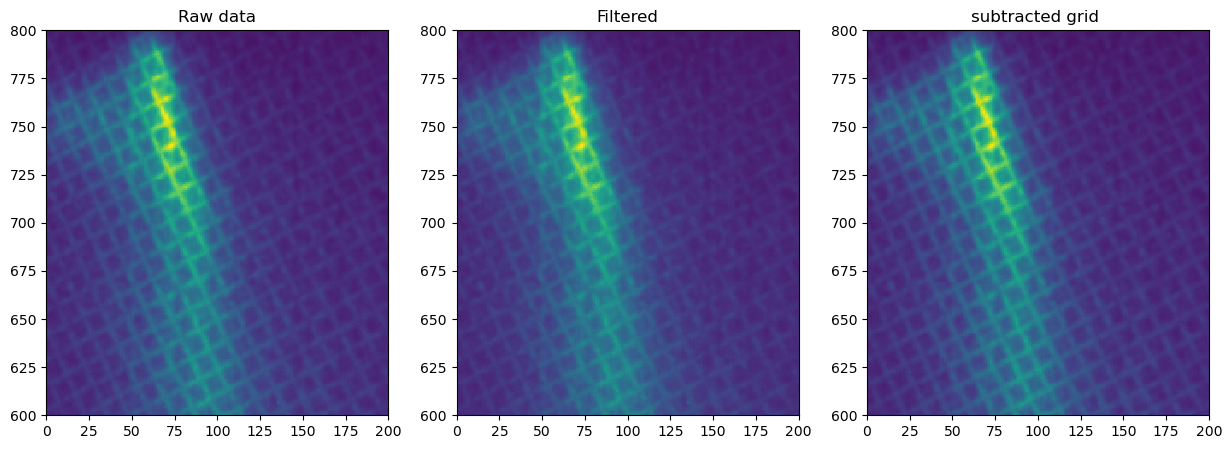

In [137]:
A = scan.sel(beta=slice(-0.1,-0.05)).sum("beta")
arpes_grid = np.array(A.spectrum)

Z_fft = sfft.fft2(np.array(arpes_grid))
# filt_ARPES  = sfft.ifftshift( sfft.fftshift(Z_fft) * grid_fft_filt)

filt_ARPES  = sfft.ifftshift( sfft.fftshift(Z_fft) * result)

arpes_filtered = np.abs(sfft.ifft2(filt_ARPES))

grid2 = arpes_grid - arpes_filtered

plt.figure(figsize = (15,5))
plt.subplot(131)
plt.pcolormesh(grid)
plt.xlim([0, 200])
plt.ylim([600, 800])
plt.title('Raw data')

plt.subplot(132)
plt.pcolormesh(arpes_filtered)
plt.xlim([0, 200])
plt.ylim([600, 800])
plt.title('Filtered')

plt.subplot(133)
plt.pcolormesh(grid2)
plt.xlim([0, 200])
plt.ylim([600, 800])
plt.title('subtracted grid ')


In [ ]:
A = scan.sel(beta=slice(-0.1,-0.05)).sum("beta")
arpes_grid = np.array(A.spectrum)

Z_fft = sfft.fft2(np.array(arpes_grid))

# Z_fft = sfft.fft2(np.array(grid2))
Z_shift = sfft.fftshift(Z_fft)

fig = plt.figure()
plt.pcolormesh( np.abs(Z_shift), vmin = 0, vmax =100)

x_points = [280, 305, 310, ]
y_points = [440, 555, 370]

# for i in range(len(x_points)):
#     plt.plot(x_points[i], y_points[i], marker = 'o', c='r')

# plt.xlim(0, 600)
# plt.ylim(200, 800)
# plt.colorbar()


# plt.figure()
grid_fft = np.abs(Z_shift)

grid_fft[grid_fft<5000] = 0

xx = np.arange(0, np.size(grid_fft,0), 1)
yy = np.arange(0, np.size(grid_fft,1), 1)
width_x = 30
width_y = 60

intX_c = np.abs(xx - np.size(grid_fft,0)) < width_x
intY_c = np.abs(yy - np.size(grid_fft,1)) < width_y
for i in range(np.size(grid_fft, 0)):
    for j in range(np.size(grid_fft,1 )):
        if (np.abs(i - np.size(grid_fft,0)/2)**2/width_x**2 + np.abs(j - np.size(grid_fft,1)/2)**2/width_y**2 < 1) :
            grid_fft[i, j ] = 0

plt.pcolormesh( medfilt2d(grid_fft, 5), vmin = 0, vmax =1e4)

grid_fft_filt =  medfilt2d(grid_fft, 5)

# grid_fft_filt[grid_fft<7.5e3] = 0 
# grid_fft_filt[grid_fft_filt==0] = 1
# grid_fft_filt[grid_fft_filt>1] = 0
plt.figure()


dx = 1
sigma = 10
gx = np.arange(-3*sigma, 3*sigma, dx)
gaussian = np.exp(-((xx-(len(xx)/2))//sigma)**2/2)

result = np.zeros(np.shape(grid_fft_filt))

for i in range(len(yy)):
    result[:,i] = np.convolve(grid_fft_filt[:,i], gaussian, mode="valid")

plt.pcolormesh( grid_fft_filt, vmin = 0, vmax =1)

plt.figure()
plt.pcolormesh( result)


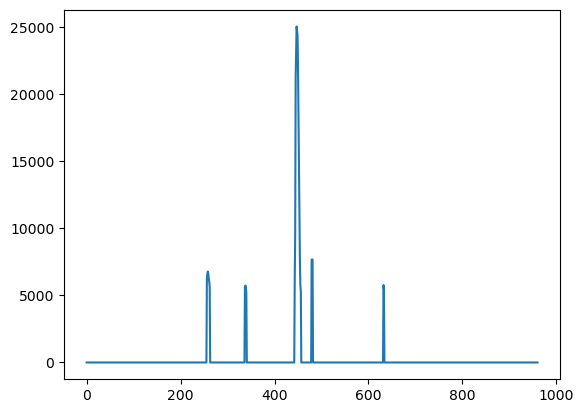

In [34]:
plt.plot(grid_fft_filt[:, 400])

In [ ]:
A = scan.sel(beta=slice(-0.1,-0.05)).sum("beta")
arpes_grid = np.array(A.spectrum)



Z_fft = sfft.fft2(np.array(arpes_grid))
filt_ARPES  = sfft.ifftshift( sfft.fftshift(Z_fft) * grid_fft_filt)


arpes_filtered = np.abs(sfft.ifft2(filt_ARPES))

grid2 = arpes_grid - arpes_filtered

plt.figure()
plt.subplot(131)
plt.pcolormesh(grid)
plt.xlim([0, 200])
plt.ylim([600, 800])

plt.subplot(132)
plt.pcolormesh(arpes_filtered)
plt.xlim([0, 200])
plt.ylim([600, 800])

plt.subplot(133)
plt.pcolormesh(grid2)
plt.xlim([0, 200])
plt.ylim([600, 800])






NameError: name 'grid_fft_filt' is not defined

C:\Users\admin-fb7365\AppData\Local\Temp\ipykernel_78536\2721388235.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


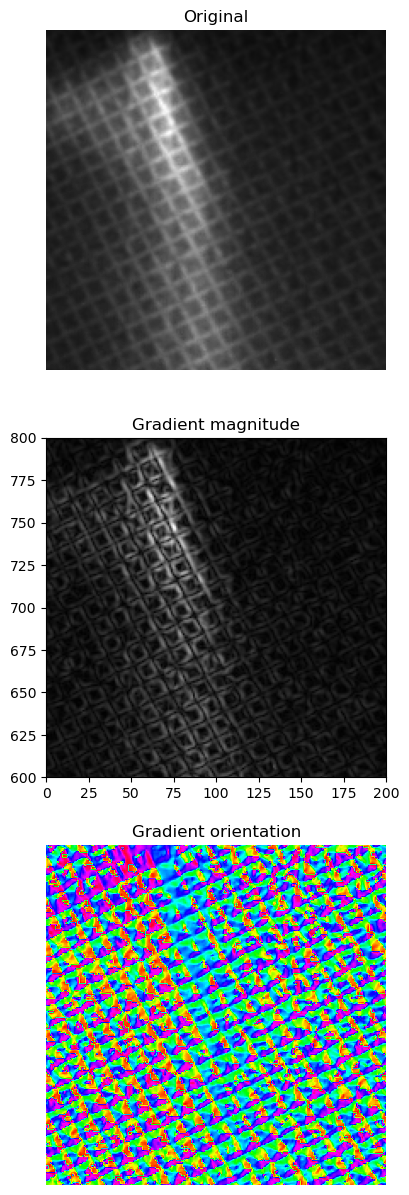

In [189]:

scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                   [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]]) # Gx + j*Gy
grad = signal.convolve2d(arpes_grid, scharr, boundary='symm', mode='same')

fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(arpes_grid, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_orig.set_xlim(0, 200)
ax_orig.set_ylim(600, 800)
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_xlim(0, 200)
ax_mag.set_ylim(600, 800)


ax_ang.imshow(np.angle(grad), cmap='hsv') # hsv is cyclic, like angles
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()
ax_ang.set_xlim(0, 200)
ax_ang.set_ylim(600, 800)
fig.show()

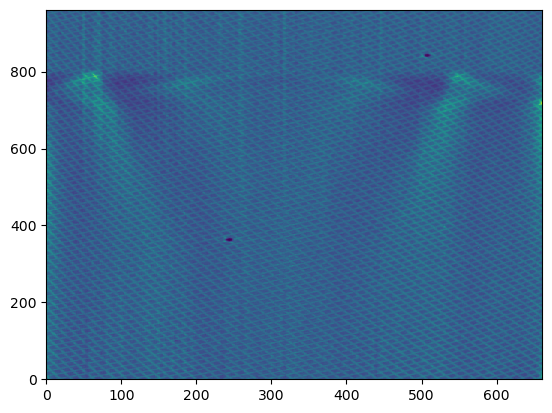

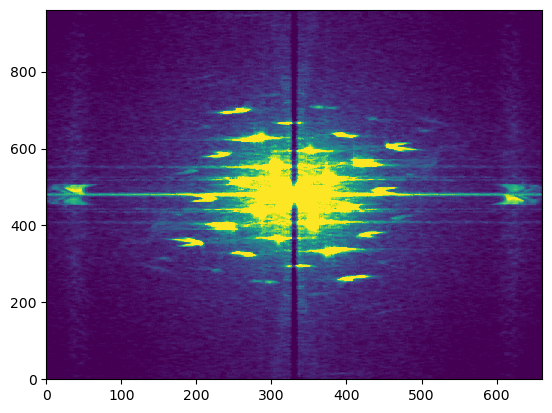

In [95]:
beta_axis = np.linspace(np.min(scan.beta), np.max(scan.beta), 25)
from scipy.signal import savgol_filter

C = []
 

grid_svd = np.zeros([961, 661])

for jj in range(961): 
    C = scan.spectrum[jj,:,:].T
    grid_svd[jj,:] = (np.mean(C, axis =0) - savgol_filter( np.mean(C, axis=0) , 301, 3))/savgol_filter( np.mean(C, axis=0) , 301, 3)


plt.pcolormesh(grid_svd)



# Z_fft = sfft.fft2(np.array(grid2))
# Z_shift = sfft.fftshift(Z_fft)

fig = plt.figure()
# plt.pcolormesh( np.abs(Z_shift), vmin = 0, vmax =100)

plt.pcolormesh( medfilt2d(np.abs(sfft.fftshift(sfft.fft2(grid_svd))), [5,7]), vmin = 10, vmax =100)


# idx = 0

# plt.figure()
# ax = plt.subplot(131)
# plt.plot(S, marker = 'o')
# ax.set_yscale('log')
# ax = plt.subplot(132)
# plt.plot(U[idx, :])
# ax = plt.subplot(133)
# plt.plot(Vh[idx, :])

# plt.figure()
# plt.subplot(211)
# plt.plot(Vh[idx, :] )
# plt.plot( savgol_filter(Vh[idx, :], 301, 3))

# plt.subplot(212)
# plt.plot(Vh[idx, :] - savgol_filter(Vh[idx, :], 301, 3) )

# print(np.size(A.spectrum, 0))

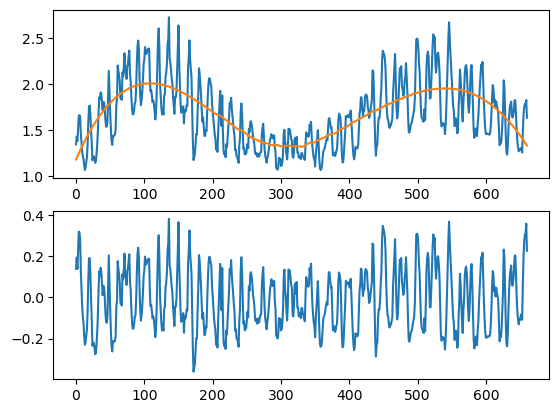

In [90]:
jj = 100
wind_size = 401

C = scan.spectrum[jj,:,:].T
grid_svd[jj,:] = np.mean(C, axis =0) - savgol_filter( np.mean(C, axis=0) , wind_size, 3)


plt.subplot(211)
plt.plot( np.mean(C, axis =0))
plt.plot(  savgol_filter( np.mean(C, axis=0) , wind_size, 3))
plt.subplot(212)
plt.plot(np.mean(C, axis =0)/savgol_filter( np.mean(C, axis=0) , wind_size, 3)-1) 



In [83]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

peaks_fft = {}
peaks_fft['pos_x'] = [277, 354, 404, 384, 303, 255, 236, 310, 383, \
    427, 450, 424, 351, 275, 230, 208, 187, 261, 334, 406, 466, 394, 321, 255]
peaks_fft['pos_y'] = [442, 407, 447, 520, 553, 510, 395, 364, 336, \
    379, 487, 560, 593, 625, 585, 469, 357, 322, 291, 258, 602, 638, 665, 696]


def fourier_filter_2d(
    image: np.ndarray,
    peaks: Sequence,
    ret: str = "filtered",
) -> np.ndarray:
    """Function to Fourier filter an image for removal of regular pattern artefacts,
       e.g. grid lines.

    Args:
        image: the input image
        peaks: list of dicts containing the following information about a "peak" in the
               Fourier image:
               'pos_x', 'pos_y', sigma_x', sigma_y', 'amplitude'. Define one entry for
               each feature you want to suppress in the Fourier image, where amplitude
               1 corresponds to full suppression.
        ret: flag to indicate which data to return. Possible values are:
             'filtered', 'fft', 'mask', 'filtered_fft'

    Returns:
        The chosen image data. Default is the filtered real image.
    """

    # Do Fourier Transform of the (real-valued) image
    image_fft = np.fft.rfft2(image)
    mask = np.ones(image_fft.shape)
    xgrid, ygrid = np.meshgrid(
        range(image_fft.shape[0]),
        range(image_fft.shape[1]),
        indexing="ij",
        sparse=True,
    )
    for peak in peaks:
        try:
            mask -= peak["amplitude"] * gauss2d(
                xgrid,
                ygrid,
                peak["pos_x"],
                peak["pos_y"],
                peak["sigma_x"],
                peak["sigma_y"],
            )
        except KeyError as exc:
            raise KeyError(
                f"The peaks input is supposed to be a list of dicts with the\
following structure: pos_x, pos_y, sigma_x, sigma_y, amplitude. The error was {exc}.",
            ) from exc

    # apply mask to the FFT, and transform back
    filtered = np.fft.irfft2(image_fft * mask)
    # strip negative values
    filtered = filtered.clip(min=0)
    if ret == "filtered":
        return filtered
    if ret == "fft":
        return image_fft
    if ret == "mask":
        return mask
    if ret == "filtered_fft":
        return image_fft * mask
    return filtered  # default return

(961, 661, 120)